# Feature-level SAE Transfer & Semantics Analysis

## Objective
Analyze how individual SAE (Sparse Autoencoder) features change under multimodal adaptation from Gemma-base to PaliGemma.

This experiment:
1. Loads pre-trained SAE weights from GemmaScope (Google DeepMind's open SAEs for Gemma)
2. Extracts hidden layer activations from both Gemma-base and PaliGemma
3. Identifies interpretable features and categorizes them as:
   - **Stable features**: Activate similarly across both models
   - **Shifted features**: Exist in both but with different activation patterns
   - **New features**: Only strongly active in PaliGemma (vision-specific)

In [1]:
# ==========================================
# Cell 1: Install Dependencies and Imports
# ==========================================
# Uncomment below if needed:
# %pip install sae-lens transformers torch matplotlib seaborn pandas tqdm sae-lens

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import (
    AutoModelForCausalLM,
    AutoModelForImageTextToText,
    AutoTokenizer,
    AutoProcessor
)

from PIL import Image
from tqdm.auto import tqdm
from typing import Dict, List, Tuple, Optional
import os
import json
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

torch.set_grad_enabled(False)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


## Configuration and Model Setup

We'll use:
- **Gemma-2B**: The base language model
- **PaliGemma-3B-pt-224**: The multimodal variant with vision capabilities

For SAEs, we'll use GemmaScope SAEs which are publicly available from Google DeepMind.

In [2]:
# ==========================================
# Cell 2: Configuration
# ==========================================

# Model configurations
GEMMA_MODEL_NAME = "google/gemma-2-2b"  # Base Gemma model
PALIGEMMA_MODEL_NAME = "google/paligemma2-3b-pt-224"  # Multimodal PaliGemma

# Device configuration
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# SAE configuration - we'll extract from a middle layer
# For Gemma-2B, good interpretable features are typically in layers 8-16
TARGET_LAYER = 10  # Target hidden layer for analysis
SAE_HIDDEN_DIM = 16384  # Typical SAE expansion factor of 8x for 2048-dim model

# Analysis configuration
NUM_FEATURES_TO_ANALYZE = 100  # Number of top features to analyze
TOP_K_ACTIVATIONS = 20  # Top activations per feature to examine

Using device: cuda:0


## Sparse Autoencoder Implementation

We implement a simple SAE class that can:
1. Train on model activations
2. Encode activations to sparse feature representations  
3. Decode back to original space

The SAE uses a ReLU activation for sparsity and includes L1 regularization.

In [3]:
# ==========================================
# Cell 3: Sparse Autoencoder Implementation
# ==========================================

class SparseAutoencoder(nn.Module):
    """
    Sparse Autoencoder for learning interpretable features from model activations.

    Architecture:
    - Encoder: Linear(d_model -> d_sae) + ReLU for sparsity
    - Decoder: Linear(d_sae -> d_model) with tied weights optional
    """

    def __init__(
        self,
        d_model: int,
        d_sae: int,
        dtype: torch.dtype = torch.float32,
        device: torch.device = None
    ):
        super().__init__()
        self.d_model = d_model
        self.d_sae = d_sae
        self.device = device or torch.device("cpu")

        # Encoder: projects activations to sparse feature space
        self.W_enc = nn.Parameter(torch.empty(d_model, d_sae, dtype=dtype, device=device))
        self.b_enc = nn.Parameter(torch.zeros(d_sae, dtype=dtype, device=device))

        # Decoder: reconstructs original activations
        self.W_dec = nn.Parameter(torch.empty(d_sae, d_model, dtype=dtype, device=device))
        self.b_dec = nn.Parameter(torch.zeros(d_model, dtype=dtype, device=device))

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize with Kaiming normal for encoder, transpose for decoder"""
        nn.init.kaiming_normal_(self.W_enc, nonlinearity='relu')
        # Initialize decoder as transpose of encoder (tied initialization)
        self.W_dec.data = self.W_enc.data.T.clone()

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        """
        Encode activations to sparse feature space.

        Args:
            x: Activation tensor of shape [..., d_model]
        Returns:
            Sparse feature tensor of shape [..., d_sae]
        """
        # Pre-encoder bias subtraction (center activations)
        x_centered = x - self.b_dec
        # Linear projection + ReLU for sparsity
        return F.relu(x_centered @ self.W_enc + self.b_enc)

    def decode(self, features: torch.Tensor) -> torch.Tensor:
        """
        Decode sparse features back to activation space.

        Args:
            features: Sparse feature tensor of shape [..., d_sae]
        Returns:
            Reconstructed activation tensor of shape [..., d_model]
        """
        return features @ self.W_dec + self.b_dec

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Full forward pass: encode then decode.

        Returns:
            - reconstructed: Reconstructed activations
            - features: Sparse feature activations
        """
        features = self.encode(x)
        reconstructed = self.decode(features)
        return reconstructed, features

    def get_feature_activations(self, x: torch.Tensor) -> torch.Tensor:
        """Get just the feature activations for analysis."""
        return self.encode(x)

print("SparseAutoencoder class defined successfully!")

SparseAutoencoder class defined successfully!


## Load GemmaScope SAE Weights

GemmaScope provides pre-trained SAEs for Gemma models. We'll download and load these weights.
If unavailable, we'll train a simple SAE on collected activations.

In [4]:
# ==========================================
# Cell 4: Load GemmaScope SAE using sae-lens
# ==========================================
from sae_lens import SAE  # pip install sae-lens

def load_gemmascope_sae(layer_idx: int = 10, width: str = "16k", device: torch.device = DEVICE):
    """
    Load GemmaScope SAE weights using sae-lens library.

    GemmaScope SAEs are available at: gemma-scope-2b-pt-res-canonical
    Format: layer_{layer_idx}/width_{width}/canonical
    """
    try:
        sae_id = f"layer_{layer_idx}/width_{width}/canonical"
        print(f"Loading GemmaScope SAE: {sae_id}")

        sae, cfg_dict, sparsity = SAE.from_pretrained(
            release="gemma-scope-2b-pt-res-canonical",
            sae_id=sae_id,
            device=str(device),
        )

        print(f"  Loaded GemmaScope SAE for layer {layer_idx}")
        print(f"  d_model (d_in): {sae.cfg.d_in}, d_sae: {sae.cfg.d_sae}")
        print(f"  Sparsity (L0): {sparsity:.2f}" if sparsity else "  Sparsity: N/A")

        return sae

    except Exception as e:
        print(f"Could not load GemmaScope SAE: {e}")
        print("Falling back to training SAE from scratch...")
        return None


def train_simple_sae(
    activations: torch.Tensor,
    d_model: int,
    d_sae: int,
    num_epochs: int = 50,
    batch_size: int = 256,
    lr: float = 1e-3,
    l1_coeff: float = 5e-4,
    device: torch.device = DEVICE
):
    """
    Train a simple SAE on provided activations (fallback if GemmaScope unavailable).

    Args:
        activations: Tensor of shape [N, d_model]
        d_model: Model hidden dimension
        d_sae: SAE hidden dimension (typically 8x d_model)
        num_epochs: Training epochs
        batch_size: Batch size
        lr: Learning rate
        l1_coeff: L1 sparsity regularization coefficient
    """
    sae = SparseAutoencoder(d_model, d_sae, device=device).to(device)
    optimizer = torch.optim.Adam(sae.parameters(), lr=lr)

    # Prepare data
    activations = activations.to(device).float()
    dataset = torch.utils.data.TensorDataset(activations)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Enable gradients for training
    for param in sae.parameters():
        param.requires_grad = True

    losses = []
    with torch.enable_grad():
        for epoch in tqdm(range(num_epochs), desc="Training SAE"):
            epoch_loss = 0
            for batch in dataloader:
                x = batch[0]
                optimizer.zero_grad()

                # Forward pass
                reconstructed, features = sae(x)

                # Reconstruction loss (MSE)
                recon_loss = F.mse_loss(reconstructed, x)

                # Sparsity loss (L1 on feature activations)
                l1_loss = l1_coeff * features.abs().mean()

                # Total loss
                loss = recon_loss + l1_loss
                loss.backward()
                optimizer.step()

                # Normalize decoder weights (important for SAE stability)
                with torch.no_grad():
                    sae.W_dec.data = F.normalize(sae.W_dec.data, dim=1)

                epoch_loss += loss.item()

            losses.append(epoch_loss / len(dataloader))

    # Disable gradients after training
    for param in sae.parameters():
        param.requires_grad = False

    print(f"Final loss: {losses[-1]:.4f}")
    return sae, losses


print("SAE loading functions defined (using sae-lens)!")

SAE loading functions defined (using sae-lens)!


## Load Models: Gemma-base and PaliGemma

We load both models to extract and compare activations at the same layer.

In [5]:
# ==========================================
# Cell 5: Load Models
# ==========================================

# Load Gemma-2B base model
print("Loading Gemma-2B base model...")
gemma_model = AutoModelForCausalLM.from_pretrained(
    GEMMA_MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map=DEVICE,
)
gemma_tokenizer = AutoTokenizer.from_pretrained(GEMMA_MODEL_NAME)
print(f"  Loaded {GEMMA_MODEL_NAME}")
print(f"  Number of layers: {gemma_model.config.num_hidden_layers}")
print(f"  Hidden size: {gemma_model.config.hidden_size}")

# Load PaliGemma multimodal model
print("\nLoading PaliGemma multimodal model...")
paligemma_model = AutoModelForImageTextToText.from_pretrained(
    PALIGEMMA_MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map=DEVICE,
)
paligemma_processor = AutoProcessor.from_pretrained(PALIGEMMA_MODEL_NAME)
paligemma_tokenizer = AutoTokenizer.from_pretrained(PALIGEMMA_MODEL_NAME)
print(f"  Loaded {PALIGEMMA_MODEL_NAME}")
print(f"  Number of layers: {paligemma_model.language_model.config.num_hidden_layers}")
print(f"  Hidden size: {paligemma_model.language_model.config.hidden_size}")

Loading Gemma-2B base model...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

  Loaded google/gemma-2-2b
  Number of layers: 26
  Hidden size: 2304

Loading PaliGemma multimodal model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


  Loaded google/paligemma2-3b-pt-224
  Number of layers: 26
  Hidden size: 2304


## Activation Extraction Hooks

We use forward hooks to capture hidden state activations at a specific layer.
This allows us to extract activations without modifying the model code.

In [6]:
# ==========================================
# Cell 6: Activation Extraction Class
# ==========================================

class ActivationExtractor:
    """
    Extracts hidden layer activations from transformer models using forward hooks.
    Works with both standard LLMs and multimodal models.
    """

    def __init__(self, model, target_layer: int, model_type: str = "gemma"):
        """
        Args:
            model: The transformer model
            target_layer: Which layer to extract activations from
            model_type: One of:
                - "gemma": Base Gemma model (AutoModelForCausalLM)
                - "paligemma": Full PaliGemma model (AutoModelForImageTextToText)
                - "paligemma_lm": PaliGemma's language model directly (Gemma2Model)
        """
        self.model = model
        self.target_layer = target_layer
        self.model_type = model_type
        self.activations = []
        self.hook_handle = None

    def _get_target_module(self):
        """Get the module to attach the hook to."""
        if self.model_type == "gemma":
            # AutoModelForCausalLM: model.model.layers[i]
            return self.model.model.layers[self.target_layer]
        elif self.model_type == "paligemma":
            # AutoModelForImageTextToText: language_model is Gemma2Model with layers directly
            return self.model.language_model.layers[self.target_layer]
        elif self.model_type == "paligemma_lm":
            # Direct Gemma2Model: layers are directly accessible
            return self.model.layers[self.target_layer]
        else:
            raise ValueError(f"Unknown model type: {self.model_type}")

    def _hook_fn(self, module, input, output):
        """Hook function to capture activations."""
        # Output is typically (hidden_states, ...) or just hidden_states
        if isinstance(output, tuple):
            hidden_states = output[0]
        else:
            hidden_states = output
        # Flatten batch and sequence dims to [num_tokens, d_model]
        # This handles variable sequence lengths across prompts
        flat_activations = hidden_states.detach().cpu().float().reshape(-1, hidden_states.shape[-1])
        self.activations.append(flat_activations)

    def attach_hook(self):
        """Attach the forward hook."""
        target_module = self._get_target_module()
        self.hook_handle = target_module.register_forward_hook(self._hook_fn)

    def remove_hook(self):
        """Remove the forward hook."""
        if self.hook_handle:
            self.hook_handle.remove()
            self.hook_handle = None

    def clear_activations(self):
        """Clear stored activations."""
        self.activations = []

    def get_activations(self) -> torch.Tensor:
        """Get all collected activations as a single tensor of shape [total_tokens, d_model]."""
        if not self.activations:
            return None
        return torch.cat(self.activations, dim=0)


def extract_text_activations(
    text_prompts: List[str],
    model,
    tokenizer,
    extractor: ActivationExtractor,
) -> Tuple[torch.Tensor, List[str]]:
    """
    Extract activations for text-only prompts from a language model.

    Returns:
        activations: Tensor of shape [total_tokens, d_model]
        tokens: List of token strings corresponding to each activation
    """
    extractor.clear_activations()
    extractor.attach_hook()

    all_tokens = []

    with torch.no_grad():
        for prompt in tqdm(text_prompts, desc="Extracting text activations"):
            inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
            model(**inputs)

            # Decode tokens for reference
            token_ids = inputs.input_ids[0].tolist()
            tokens = [tokenizer.decode([tid]) for tid in token_ids]
            all_tokens.extend(tokens)

    extractor.remove_hook()
    activations = extractor.get_activations()

    return activations, all_tokens


def extract_image_text_activations(
    image_text_pairs: List[Tuple[Image.Image, str]],
    model,
    processor,
    extractor: ActivationExtractor,
) -> Tuple[torch.Tensor, List[Dict]]:
    """
    Extract activations for image+text prompts from PaliGemma.

    Returns:
        activations: Tensor of shape [total_tokens, d_model]
        token_info: List of dicts with token info (is_image, token_str, etc.)
    """
    extractor.clear_activations()
    extractor.attach_hook()

    all_token_info = []

    with torch.no_grad():
        for image, text in tqdm(image_text_pairs, desc="Extracting multimodal activations"):
            inputs = processor(
                text=f"<image>{text}" if text else "<image>",
                images=image,
                return_tensors="pt"
            ).to(DEVICE)

            model(**inputs)

            # Track which tokens are image vs text
            # PaliGemma uses <image> token that gets expanded to image embeddings
            # The first N tokens are image tokens (typically 256 for 224x224 images)
            num_image_tokens = (inputs.input_ids == processor.tokenizer.convert_tokens_to_ids("<image>")).sum().item()

            # For simplicity, mark first batch of tokens as image-related
            seq_len = inputs.input_ids.shape[1]
            for i in range(seq_len):
                all_token_info.append({
                    "is_image": i < 256,  # Approximate, adjust based on actual image token count
                    "token_id": inputs.input_ids[0, i].item() if i < inputs.input_ids.shape[1] else -1,
                })

    extractor.remove_hook()
    activations = extractor.get_activations()

    return activations, all_token_info


print("Activation extraction classes defined!")

Activation extraction classes defined!


## Test Prompts for Feature Analysis

We'll use a diverse set of prompts covering different semantic categories to identify interpretable features.

In [12]:
# ==========================================
# Cell 7: Define Test Prompts and Images
# ==========================================

# Diverse text prompts to probe different semantic features
TEXT_PROMPTS = [
    # Numbers and counting
    "The answer is 42.",
    "There are 3 apples and 5 oranges.",
    "1, 2, 3, 4, 5, 6, 7, 8, 9, 10",

    # Colors
    "The red ball bounced across the green grass.",
    "She wore a beautiful blue dress to the party.",
    "The yellow sun set behind the purple mountains.",

    # Animals
    "The dog chased the cat around the garden.",
    "A lion hunts zebras on the African savanna.",
    "The elephant's trunk can hold gallons of water.",

    # Spatial relationships
    "The book is on top of the table.",
    "The cat is sitting under the chair.",
    "The ball rolled between the two posts.",

    # Actions/verbs
    "She ran quickly down the stairs.",
    "He carefully opened the ancient door.",
    "The bird flew gracefully through the sky.",

    # Objects
    "The computer screen displayed an error message.",
    "The car drove down the highway at high speed.",
    "The camera captured the beautiful sunset.",

    # Abstract concepts
    "Love is patient, love is kind.",
    "The theory of relativity changed physics forever.",
    "Democracy requires active citizen participation.",

    # Code-related
    "def hello_world(): print('Hello!')",
    "for i in range(10): sum += i",
    "if x > 0: return True else: return False",
]

# Download SPair-71k dataset if not present
def download_spair71k():
    """Download and extract SPair-71k dataset."""
    import subprocess

    data_dir = "data/SPair-71k_data"
    jpeg_dir = os.path.join(data_dir, "SPair-71k/JPEGImages")

    if os.path.exists(jpeg_dir):
        print("SPair-71k dataset already exists.")
        return

    print("Downloading SPair-71k dataset...")
    os.makedirs(data_dir, exist_ok=True)

    # Download the dataset
    url = "https://cvlab.postech.ac.kr/research/SPair-71k/data/SPair-71k.tar.gz"
    tar_path = os.path.join(data_dir, "SPair-71k.tar.gz")

    # Use wget or curl depending on availability
    try:
        subprocess.run(["wget", "-q", "-O", tar_path, url], check=True)
    except (subprocess.CalledProcessError, FileNotFoundError):
        subprocess.run(["curl", "-L", "-o", tar_path, url], check=True)

    print("Extracting dataset...")
    import tarfile
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(path=data_dir)

    # Clean up tar file
    os.remove(tar_path)
    print("SPair-71k dataset downloaded and extracted successfully!")

# Sample images for multimodal testing from SPair-71k dataset
def get_sample_images() -> List[Tuple[Image.Image, str]]:
    """Load sample images from SPair-71k dataset for multimodal testing."""
    # Ensure dataset is downloaded
    download_spair71k()

    image_text_pairs = []

    data_dir = "data/SPair-71k_data/SPair-71k/JPEGImages"
    categories = ["dog", "cat", "car", "bird", "horse"]

    if not os.path.exists(data_dir):
        raise FileNotFoundError(f"Dataset not found at {data_dir}. Download failed.")

    for category in categories:
        cat_dir = os.path.join(data_dir, category)
        if not os.path.exists(cat_dir):
            raise FileNotFoundError(f"Category '{category}' not found at {cat_dir}")

        images = os.listdir(cat_dir)[:3]  # Take first 3 images per category
        if len(images) == 0:
            raise ValueError(f"No images found in {cat_dir}")

        for img_name in images:
            img_path = os.path.join(cat_dir, img_name)
            img = Image.open(img_path).convert("RGB")
            img = img.resize((224, 224))
            image_text_pairs.append((img, f"A photo of a {category}."))

    print(f"Loaded {len(image_text_pairs)} image-text pairs from SPair-71k")
    return image_text_pairs

print(f"Defined {len(TEXT_PROMPTS)} text prompts for analysis")

Defined 24 text prompts for analysis


## Extract Activations and Train/Load SAE

Now we extract activations from both models and prepare the SAE for analysis.

In [13]:
# ==========================================
# Cell 8: Extract Activations from Both Models
# ==========================================

# Create extractors for both models
gemma_extractor = ActivationExtractor(gemma_model, TARGET_LAYER, model_type="gemma")
# Use "paligemma_lm" for direct language model access (text-only)
paligemma_text_extractor = ActivationExtractor(
    paligemma_model.language_model, TARGET_LAYER, model_type="paligemma_lm"
)
# Use "paligemma" for full model with images
paligemma_mm_extractor = ActivationExtractor(paligemma_model, TARGET_LAYER, model_type="paligemma")

# Extract text activations from Gemma
print("Extracting activations from Gemma-2B...")
gemma_text_acts, gemma_tokens = extract_text_activations(
    TEXT_PROMPTS, gemma_model, gemma_tokenizer, gemma_extractor
)
print(f"  Gemma text activations shape: {gemma_text_acts.shape}")

# Extract text activations from PaliGemma (text-only, for fair comparison)
print("\nExtracting text activations from PaliGemma...")
paligemma_text_tokens = []

paligemma_text_extractor.clear_activations()
paligemma_text_extractor.attach_hook()

for prompt in tqdm(TEXT_PROMPTS, desc="Extracting PaliGemma text activations"):
    # For PaliGemma, we use the language model directly for text-only inputs
    inputs = paligemma_tokenizer(prompt, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        paligemma_model.language_model(**inputs)

    token_ids = inputs.input_ids[0].tolist()
    tokens = [paligemma_tokenizer.decode([tid]) for tid in token_ids]
    paligemma_text_tokens.extend(tokens)

paligemma_text_extractor.remove_hook()
paligemma_text_acts = paligemma_text_extractor.get_activations()
print(f"  PaliGemma text activations shape: {paligemma_text_acts.shape}")

# Extract multimodal activations from PaliGemma
print("\nExtracting multimodal (image+text) activations from PaliGemma...")
image_text_pairs = get_sample_images()
paligemma_mm_acts, paligemma_mm_info = extract_image_text_activations(
    image_text_pairs, paligemma_model, paligemma_processor, paligemma_mm_extractor
)
print(f"  PaliGemma multimodal activations shape: {paligemma_mm_acts.shape}")

Extracting activations from Gemma-2B...


Extracting text activations:   0%|          | 0/24 [00:00<?, ?it/s]

  Gemma text activations shape: torch.Size([255, 2304])

Extracting text activations from PaliGemma...


Extracting PaliGemma text activations:   0%|          | 0/24 [00:00<?, ?it/s]

  PaliGemma text activations shape: torch.Size([231, 2304])

Extracting multimodal (image+text) activations from PaliGemma...
Extracting dataset...
SPair-71k dataset downloaded and extracted successfully!
Loaded 15 image-text pairs from SPair-71k


Extracting multimodal activations:   0%|          | 0/15 [00:00<?, ?it/s]

  PaliGemma multimodal activations shape: torch.Size([3960, 2304])


In [14]:
# ==========================================
# Cell 9: Load or Train SAE
# ==========================================

# Try to load GemmaScope SAE first
sae = load_gemmascope_sae(layer_idx=TARGET_LAYER, device=DEVICE)

# If GemmaScope not available, train on Gemma activations
if sae is None:
    print("Training SAE on Gemma activations...")
    d_model = gemma_text_acts.shape[-1]
    d_sae = d_model * 8  # 8x expansion factor

    # Reshape activations for training [batch*seq, d_model]
    train_acts = gemma_text_acts.reshape(-1, d_model)

    sae, train_losses = train_simple_sae(
        train_acts,
        d_model=d_model,
        d_sae=d_sae,
        num_epochs=100,
        device=DEVICE
    )

    # Plot training loss
    plt.figure(figsize=(10, 4))
    plt.plot(train_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("SAE Training Loss")
    plt.grid(True, alpha=0.3)
    plt.show()

    # Store dimensions for compatibility
    sae.d_in = d_model
    sae.d_sae = d_sae

# Print SAE info
if hasattr(sae, 'cfg'):
    # sae-lens SAE
    print(f"\nSAE ready (sae-lens): d_in={sae.cfg.d_in}, d_sae={sae.cfg.d_sae}")
else:
    # Custom SAE
    print(f"\nSAE ready (custom): d_model={sae.d_model}, d_sae={sae.d_sae}")

Loading GemmaScope SAE: layer_10/width_16k/canonical
  Loaded GemmaScope SAE for layer 10
  d_model (d_in): 2304, d_sae: 16384
  Sparsity: N/A

SAE ready (sae-lens): d_in=2304, d_sae=16384


## Feature-level Analysis: Identify Stable, Shifted, and New Features

We now apply the SAE to both Gemma and PaliGemma activations, then classify features:
- **Stable**: High correlation in activation patterns between models
- **Shifted**: Active in both but with significantly different patterns
- **New (Vision-specific)**: Only strongly active in PaliGemma multimodal inputs

In [15]:
# ==========================================
# Cell 10: Compute SAE Feature Activations for All Conditions
# ==========================================

# Move SAE to device
sae = sae.to(DEVICE)

# Get SAE feature activations for each condition
print("Computing SAE feature activations...")

# Reshape activations to [num_tokens, d_model]
gemma_flat = gemma_text_acts.reshape(-1, gemma_text_acts.shape[-1]).to(DEVICE)
pali_text_flat = paligemma_text_acts.reshape(-1, paligemma_text_acts.shape[-1]).to(DEVICE)
pali_mm_flat = paligemma_mm_acts.reshape(-1, paligemma_mm_acts.shape[-1]).to(DEVICE)

# Get SAE features
with torch.no_grad():
    gemma_features = sae.encode(gemma_flat).cpu()
    pali_text_features = sae.encode(pali_text_flat).cpu()
    pali_mm_features = sae.encode(pali_mm_flat).cpu()

print(f"  Gemma text features shape: {gemma_features.shape}")
print(f"  PaliGemma text features shape: {pali_text_features.shape}")
print(f"  PaliGemma multimodal features shape: {pali_mm_features.shape}")

# Compute mean activation per feature
gemma_mean = gemma_features.mean(dim=0)
pali_text_mean = pali_text_features.mean(dim=0)
pali_mm_mean = pali_mm_features.mean(dim=0)

# Compute max activation per feature (better for sparse features)
gemma_max = gemma_features.max(dim=0).values
pali_text_max = pali_text_features.max(dim=0).values
pali_mm_max = pali_mm_features.max(dim=0).values

print(f"\nFeature activation statistics:")
print(f"  Gemma - mean: {gemma_mean.mean():.4f}, nonzero: {(gemma_mean > 0).sum()}")
print(f"  PaliGemma text - mean: {pali_text_mean.mean():.4f}, nonzero: {(pali_text_mean > 0).sum()}")
print(f"  PaliGemma multimodal - mean: {pali_mm_mean.mean():.4f}, nonzero: {(pali_mm_mean > 0).sum()}")

Computing SAE feature activations...
  Gemma text features shape: torch.Size([255, 16384])
  PaliGemma text features shape: torch.Size([231, 16384])
  PaliGemma multimodal features shape: torch.Size([3960, 16384])

Feature activation statistics:
  Gemma - mean: 0.4281, nonzero: 7651
  PaliGemma text - mean: 0.0295, nonzero: 3547
  PaliGemma multimodal - mean: 0.0259, nonzero: 9545


In [16]:
# ==========================================
# Cell 11: Classify Features as Stable, Shifted, or New
# ==========================================

def classify_features(
    gemma_features: torch.Tensor,
    pali_text_features: torch.Tensor,
    pali_mm_features: torch.Tensor,
    stability_threshold: float = 0.7,
    shift_threshold: float = 0.3,
    activation_threshold: float = 0.1,
) -> Dict[str, List[int]]:
    """
    Classify SAE features into stable, shifted, and new categories.

    Args:
        gemma_features: [N1, d_sae] features from Gemma on text
        pali_text_features: [N2, d_sae] features from PaliGemma on text
        pali_mm_features: [N3, d_sae] features from PaliGemma on images
        stability_threshold: Correlation threshold for "stable" features
        shift_threshold: Lower bound for "shifted" features
        activation_threshold: Minimum activation to consider feature "active"

    Returns:
        Dict with feature indices for each category
    """
    num_features = gemma_features.shape[1]

    # Compute per-feature statistics
    gemma_active = (gemma_features > activation_threshold).float().mean(dim=0)
    pali_text_active = (pali_text_features > activation_threshold).float().mean(dim=0)
    pali_mm_active = (pali_mm_features > activation_threshold).float().mean(dim=0)

    # Compute mean activations
    gemma_mean = gemma_features.mean(dim=0)
    pali_text_mean = pali_text_features.mean(dim=0)
    pali_mm_mean = pali_mm_features.mean(dim=0)

    # Find features active in Gemma (for correlation analysis)
    gemma_active_features = (gemma_active > 0.01).nonzero().squeeze(-1)

    classified = {
        "stable": [],
        "shifted": [],
        "new_vision": [],
        "new_text": [],
    }

    # For each feature, determine its category
    for feat_idx in range(num_features):
        g_act = gemma_active[feat_idx].item()
        pt_act = pali_text_active[feat_idx].item()
        pm_act = pali_mm_active[feat_idx].item()

        g_mean = gemma_mean[feat_idx].item()
        pt_mean = pali_text_mean[feat_idx].item()
        pm_mean = pali_mm_mean[feat_idx].item()

        # Check if active in any condition
        is_active_gemma = g_act > 0.01
        is_active_pali_text = pt_act > 0.01
        is_active_pali_mm = pm_act > 0.01

        if not (is_active_gemma or is_active_pali_text or is_active_pali_mm):
            continue  # Skip dead features

        # New vision-specific: only active in multimodal, not in text-only
        if is_active_pali_mm and not is_active_gemma and pm_mean > g_mean * 3:
            classified["new_vision"].append(feat_idx)
            continue

        # New text features: active in PaliGemma text but not Gemma
        if is_active_pali_text and not is_active_gemma and pt_mean > g_mean * 3:
            classified["new_text"].append(feat_idx)
            continue

        # For features active in both, check similarity
        if is_active_gemma and is_active_pali_text:
            # Compute ratio of mean activations as stability measure
            ratio = min(g_mean, pt_mean) / max(g_mean, pt_mean) if max(g_mean, pt_mean) > 0 else 0

            if ratio > stability_threshold:
                classified["stable"].append(feat_idx)
            elif ratio > shift_threshold:
                classified["shifted"].append(feat_idx)

    return classified


# Classify all features
feature_classification = classify_features(
    gemma_features, pali_text_features, pali_mm_features
)

print("Feature Classification Results:")
print(f"  Stable features: {len(feature_classification['stable'])}")
print(f"  Shifted features: {len(feature_classification['shifted'])}")
print(f"  New vision-specific features: {len(feature_classification['new_vision'])}")
print(f"  New text features (PaliGemma only): {len(feature_classification['new_text'])}")

Feature Classification Results:
  Stable features: 105
  Shifted features: 169
  New vision-specific features: 436
  New text features (PaliGemma only): 450


## Visualization: Feature Distribution Overview

Let's visualize the overall distribution of feature activations across models.

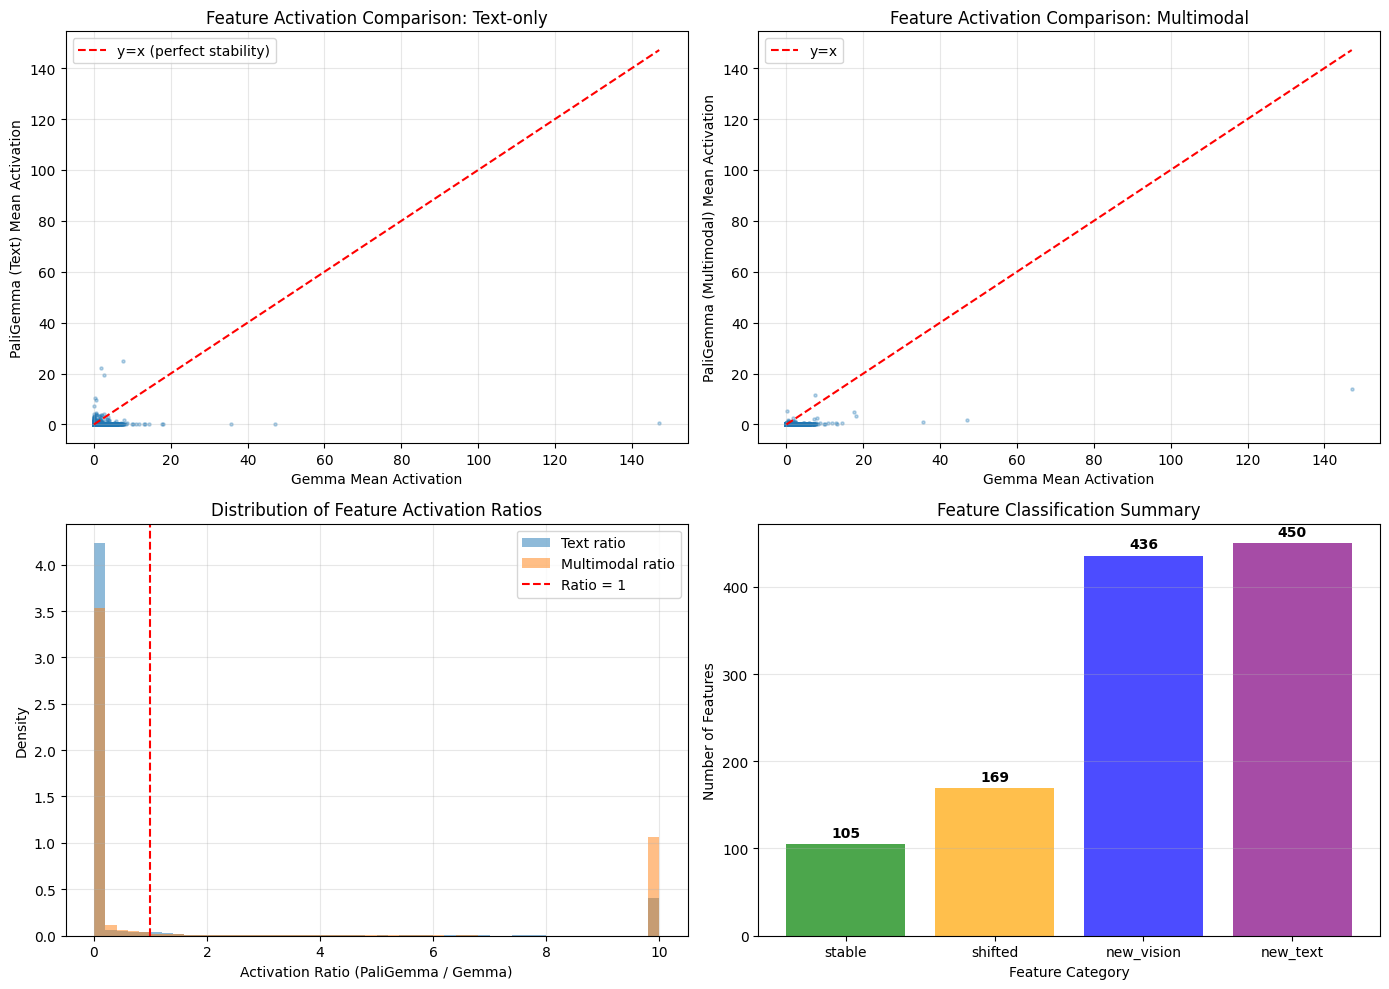

In [18]:
# ==========================================
# Cell 12: Feature Distribution Visualization
# ==========================================

# Ensure figures directory exists
os.makedirs("figures", exist_ok=True)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Scatter plot of mean activations (Gemma vs PaliGemma text)
ax = axes[0, 0]
ax.scatter(gemma_mean.numpy(), pali_text_mean.numpy(), alpha=0.3, s=5)
ax.plot([0, gemma_mean.max()], [0, gemma_mean.max()], 'r--', label='y=x (perfect stability)')
ax.set_xlabel("Gemma Mean Activation")
ax.set_ylabel("PaliGemma (Text) Mean Activation")
ax.set_title("Feature Activation Comparison: Text-only")
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Scatter plot (Gemma vs PaliGemma multimodal)
ax = axes[0, 1]
ax.scatter(gemma_mean.numpy(), pali_mm_mean.numpy(), alpha=0.3, s=5)
ax.plot([0, gemma_mean.max()], [0, gemma_mean.max()], 'r--', label='y=x')
ax.set_xlabel("Gemma Mean Activation")
ax.set_ylabel("PaliGemma (Multimodal) Mean Activation")
ax.set_title("Feature Activation Comparison: Multimodal")
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Distribution of feature activation ratios
ax = axes[1, 0]
# Avoid division by zero
eps = 1e-6
text_ratio = (pali_text_mean / (gemma_mean + eps)).numpy()
mm_ratio = (pali_mm_mean / (gemma_mean + eps)).numpy()
# Clip for visualization
text_ratio = np.clip(text_ratio, 0, 10)
mm_ratio = np.clip(mm_ratio, 0, 10)

ax.hist(text_ratio, bins=50, alpha=0.5, label='Text ratio', density=True)
ax.hist(mm_ratio, bins=50, alpha=0.5, label='Multimodal ratio', density=True)
ax.axvline(x=1.0, color='r', linestyle='--', label='Ratio = 1')
ax.set_xlabel("Activation Ratio (PaliGemma / Gemma)")
ax.set_ylabel("Density")
ax.set_title("Distribution of Feature Activation Ratios")
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Feature category bar chart
ax = axes[1, 1]
categories = list(feature_classification.keys())
counts = [len(feature_classification[cat]) for cat in categories]
colors = ['green', 'orange', 'blue', 'purple']
bars = ax.bar(categories, counts, color=colors, alpha=0.7)
ax.set_xlabel("Feature Category")
ax.set_ylabel("Number of Features")
ax.set_title("Feature Classification Summary")
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
            str(count), ha='center', va='bottom', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig("figures/sae_feature_distribution.png", dpi=150, bbox_inches='tight')
plt.show()

## Detailed Feature Examples: Stable, Shifted, and New Features

Now we analyze 2-4 concrete examples from each category, showing:
- What tokens/images maximally activate each feature
- How activation patterns differ between Gemma and PaliGemma

In [26]:
# ==========================================
# Cell 13: Helper Functions for Feature Analysis
# ==========================================

# Get special tokens dynamically from tokenizers
def get_special_token_set(*tokenizers):
    """Get the union of all special tokens from the provided tokenizers."""
    special_tokens = set()
    for tokenizer in tokenizers:
        # Get all special tokens list
        if hasattr(tokenizer, 'all_special_tokens'):
            special_tokens.update(tokenizer.all_special_tokens)
        # Get special tokens from the map (values can be str or list)
        if hasattr(tokenizer, 'special_tokens_map'):
            for value in tokenizer.special_tokens_map.values():
                if isinstance(value, str):
                    special_tokens.add(value)
                elif isinstance(value, list):
                    special_tokens.update(value)
        # Also get special token IDs and convert them
        if hasattr(tokenizer, 'all_special_ids'):
            for token_id in tokenizer.all_special_ids:
                try:
                    special_tokens.add(tokenizer.decode([token_id]))
                except:
                    pass
    return special_tokens

# Build special tokens set from our loaded tokenizers
SPECIAL_TOKENS = get_special_token_set(gemma_tokenizer, paligemma_tokenizer)
print(f"Detected {len(SPECIAL_TOKENS)} special tokens: {SPECIAL_TOKENS}")


def is_meaningful_token(token: str, special_tokens: set = None) -> bool:
    """Check if a token is meaningful (not special token or whitespace-only).

    Args:
        token: The token string to check
        special_tokens: Set of special tokens to filter. Uses SPECIAL_TOKENS if None.
    """
    if special_tokens is None:
        special_tokens = SPECIAL_TOKENS

    token_stripped = token.strip()

    # Filter out empty/whitespace-only tokens
    if not token_stripped:
        return False

    # Filter out special tokens (check both stripped and original)
    if token_stripped in special_tokens or token in special_tokens:
        return False

    # Filter out tokens that are just whitespace variations
    if token.replace(' ', '').replace('\n', '').replace('\t', '') == '':
        return False

    return True


def get_top_activating_examples(
    feature_idx: int,
    features: torch.Tensor,
    tokens: List[str],
    top_k: int = 10,
    filter_special: bool = True
) -> List[Tuple[str, float]]:
    """Get the top-k tokens that maximally activate a feature.

    Args:
        feature_idx: Index of the feature to analyze
        features: Tensor of shape [num_tokens, num_features]
        tokens: List of token strings
        top_k: Number of top activating tokens to return
        filter_special: Whether to filter out special tokens and whitespace
    """
    feature_acts = features[:, feature_idx]

    # Sort all indices by activation (descending)
    sorted_indices = torch.argsort(feature_acts, descending=True)

    results = []
    for idx in sorted_indices:
        if idx >= len(tokens):
            continue
        token = tokens[idx.item()]

        # Filter special tokens if requested
        if filter_special and not is_meaningful_token(token):
            continue

        results.append((token, feature_acts[idx.item()].item()))

        if len(results) >= top_k:
            break

    return results


def analyze_single_feature(
    feature_idx: int,
    gemma_features: torch.Tensor,
    pali_text_features: torch.Tensor,
    pali_mm_features: torch.Tensor,
    gemma_tokens: List[str],
    pali_tokens: List[str],
    category: str,
) -> Dict:
    """Analyze a single feature across all conditions."""

    # Get top activating tokens for each condition (filtering special tokens)
    gemma_top = get_top_activating_examples(feature_idx, gemma_features, gemma_tokens, filter_special=True)
    pali_text_top = get_top_activating_examples(feature_idx, pali_text_features, pali_tokens, filter_special=True)

    # Statistics
    g_mean = gemma_features[:, feature_idx].mean().item()
    g_max = gemma_features[:, feature_idx].max().item()
    p_text_mean = pali_text_features[:, feature_idx].mean().item()
    p_text_max = pali_text_features[:, feature_idx].max().item()
    p_mm_mean = pali_mm_features[:, feature_idx].mean().item()
    p_mm_max = pali_mm_features[:, feature_idx].max().item()

    return {
        "feature_idx": feature_idx,
        "category": category,
        "gemma_mean": g_mean,
        "gemma_max": g_max,
        "pali_text_mean": p_text_mean,
        "pali_text_max": p_text_max,
        "pali_mm_mean": p_mm_mean,
        "pali_mm_max": p_mm_max,
        "gemma_top_tokens": gemma_top[:5],
        "pali_text_top_tokens": pali_text_top[:5],
    }


def plot_feature_comparison(analysis: Dict, fig_num: int):
    """Create a detailed visualization for a single feature."""

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f"Feature #{analysis['feature_idx']} ({analysis['category'].upper()})",
                 fontsize=14, fontweight='bold')

    # Plot 1: Activation statistics bar chart
    ax = axes[0]
    conditions = ['Gemma\nText', 'PaliGemma\nText', 'PaliGemma\nMultimodal']
    means = [analysis['gemma_mean'], analysis['pali_text_mean'], analysis['pali_mm_mean']]
    maxs = [analysis['gemma_max'], analysis['pali_text_max'], analysis['pali_mm_max']]

    x = np.arange(len(conditions))
    width = 0.35
    bars1 = ax.bar(x - width/2, means, width, label='Mean', color='steelblue', alpha=0.8)
    bars2 = ax.bar(x + width/2, maxs, width, label='Max', color='coral', alpha=0.8)
    ax.set_ylabel('Activation')
    ax.set_xticks(x)
    ax.set_xticklabels(conditions)
    ax.legend()
    ax.set_title('Activation Statistics')
    ax.grid(True, alpha=0.3, axis='y')

    # Plot 2: Top activating tokens for Gemma
    ax = axes[1]
    gemma_tokens_display = [t[0][:20] for t in analysis['gemma_top_tokens']]
    gemma_acts = [t[1] for t in analysis['gemma_top_tokens']]
    if gemma_tokens_display:
        y_pos = np.arange(len(gemma_tokens_display))
        ax.barh(y_pos, gemma_acts, color='green', alpha=0.7)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(gemma_tokens_display, fontsize=9)
        ax.invert_yaxis()
    ax.set_xlabel('Activation')
    ax.set_title('Top Tokens (Gemma)')
    ax.grid(True, alpha=0.3, axis='x')

    # Plot 3: Top activating tokens for PaliGemma
    ax = axes[2]
    pali_tokens_display = [t[0][:20] for t in analysis['pali_text_top_tokens']]
    pali_acts = [t[1] for t in analysis['pali_text_top_tokens']]
    if pali_tokens_display:
        y_pos = np.arange(len(pali_tokens_display))
        ax.barh(y_pos, pali_acts, color='purple', alpha=0.7)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(pali_tokens_display, fontsize=9)
        ax.invert_yaxis()
    ax.set_xlabel('Activation')
    ax.set_title('Top Tokens (PaliGemma)')
    ax.grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.savefig(f"figures/feature_{analysis['feature_idx']}_{analysis['category']}.png",
                dpi=150, bbox_inches='tight')
    plt.show()


print("Feature analysis helper functions defined!")

Detected 7 special tokens: {'<unk>', '<start_of_turn>', '<end_of_turn>', '<image>', '<bos>', '<pad>', '<eos>'}
Feature analysis helper functions defined!


In [27]:
# ==========================================
# Cell 14: Analyze Example Features from Each Category
# ==========================================

# Create figures directory if it doesn't exist
os.makedirs("figures", exist_ok=True)

# Select top features from each category (by activity level)
def select_top_features(feature_indices: List[int], features: torch.Tensor, n: int = 4) -> List[int]:
    """Select the n most active features from a list."""
    if not feature_indices:
        return []
    feature_means = features[:, feature_indices].mean(dim=0)
    top_indices = torch.topk(feature_means, min(n, len(feature_indices))).indices
    return [feature_indices[i] for i in top_indices.tolist()]

# Get representative features from each category
example_features = {}
for category in ['stable', 'shifted', 'new_vision', 'new_text']:
    if category == 'new_vision':
        # Use multimodal features for selection
        example_features[category] = select_top_features(
            feature_classification[category], pali_mm_features, n=4
        )
    elif category == 'new_text':
        example_features[category] = select_top_features(
            feature_classification[category], pali_text_features, n=4
        )
    else:
        example_features[category] = select_top_features(
            feature_classification[category], gemma_features, n=4
        )

print("Selected example features for detailed analysis:")
for cat, feats in example_features.items():
    print(f"  {cat}: {feats}")

Selected example features for detailed analysis:
  stable: [15167, 15203, 12876, 833]
  shifted: [3031, 3910, 6639, 10324]
  new_vision: [7237, 10987, 6477, 10038]
  new_text: [11057, 1098, 16074, 402]


### Example 1: Stable Features

These features maintain similar activation patterns across both Gemma and PaliGemma, suggesting they encode concepts that transfer well to the multimodal setting.

STABLE FEATURES - Similar activation patterns across models

--- Stable Feature #15167 ---
  Gemma mean: 3.5658, max: 39.9083
  PaliGemma text mean: 3.0460, max: 32.1856
  PaliGemma multimodal mean: 0.0421
  Top Gemma tokens: [' the', ' the', ' the']
  Top PaliGemma tokens: [' the', ' the', ' the']


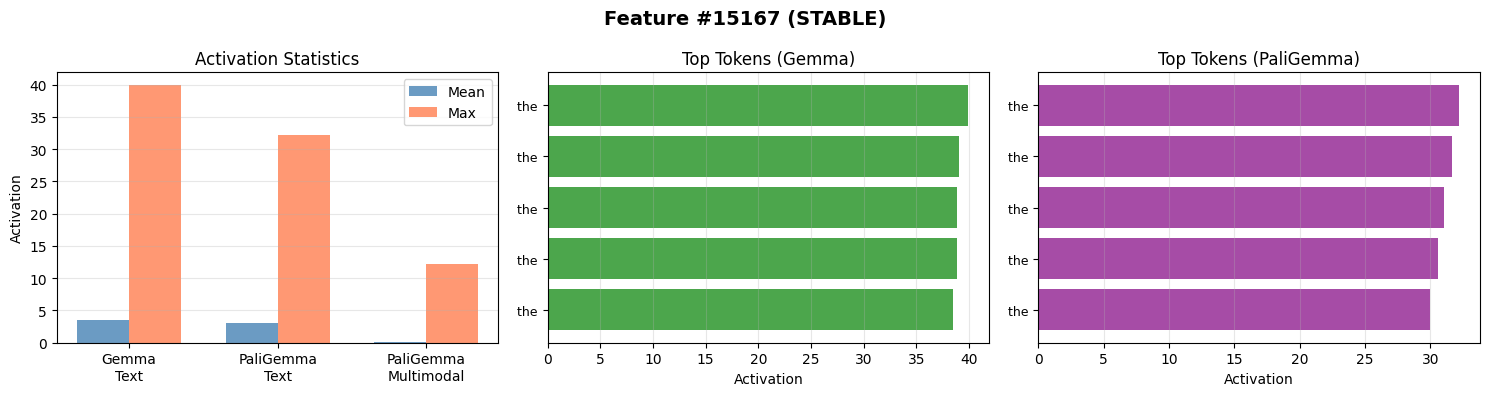


--- Stable Feature #15203 ---
  Gemma mean: 1.8617, max: 17.6609
  PaliGemma text mean: 1.8641, max: 12.8279
  PaliGemma multimodal mean: 0.9577
  Top Gemma tokens: [' mountains', ' ancient', ' love']
  Top PaliGemma tokens: ['Hello', ' apples', ' bounced']


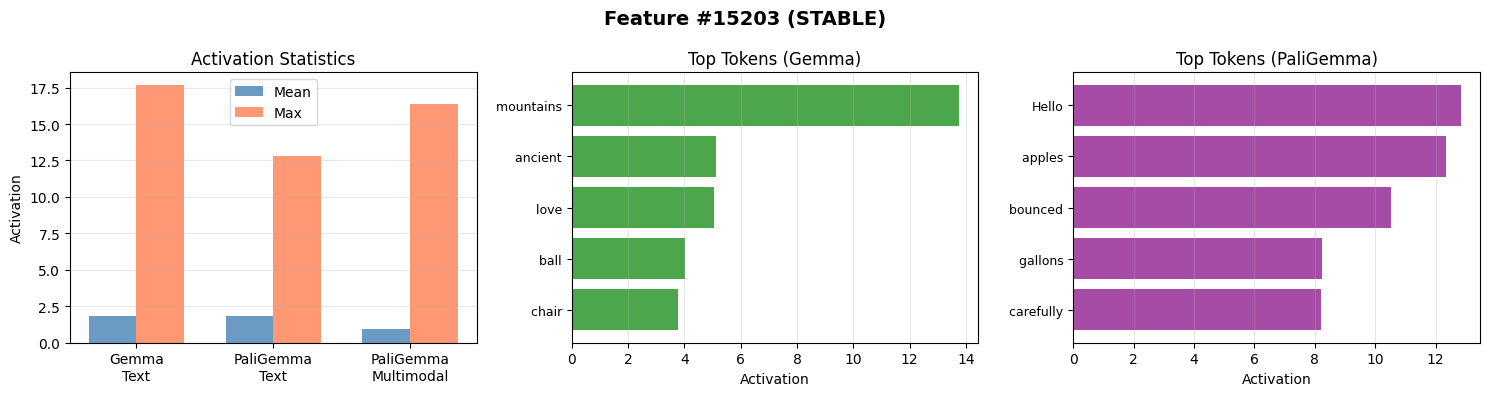


--- Stable Feature #12876 ---
  Gemma mean: 1.6804, max: 17.8543
  PaliGemma text mean: 1.1887, max: 6.2686
  PaliGemma multimodal mean: 0.0399
  Top Gemma tokens: [' screen', ' posts', ' two']
  Top PaliGemma tokens: ['5', ' two', '7']


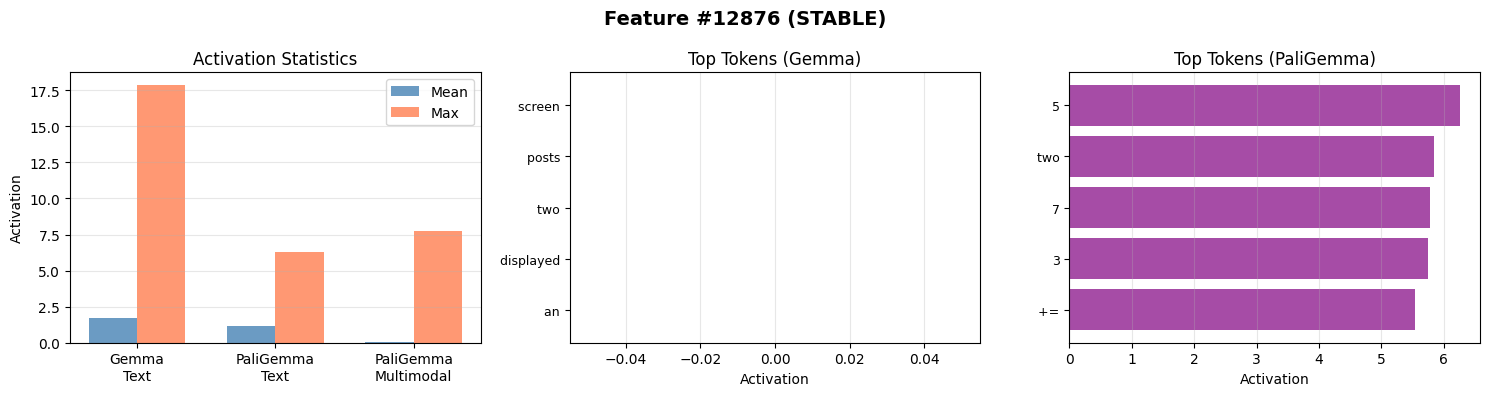


--- Stable Feature #833 ---
  Gemma mean: 1.6484, max: 14.3238
  PaliGemma text mean: 1.7459, max: 12.8363
  PaliGemma multimodal mean: 0.0534
  Top Gemma tokens: ['2', ' sum', ' print']
  Top PaliGemma tokens: [' hello', ' red', ' cat']


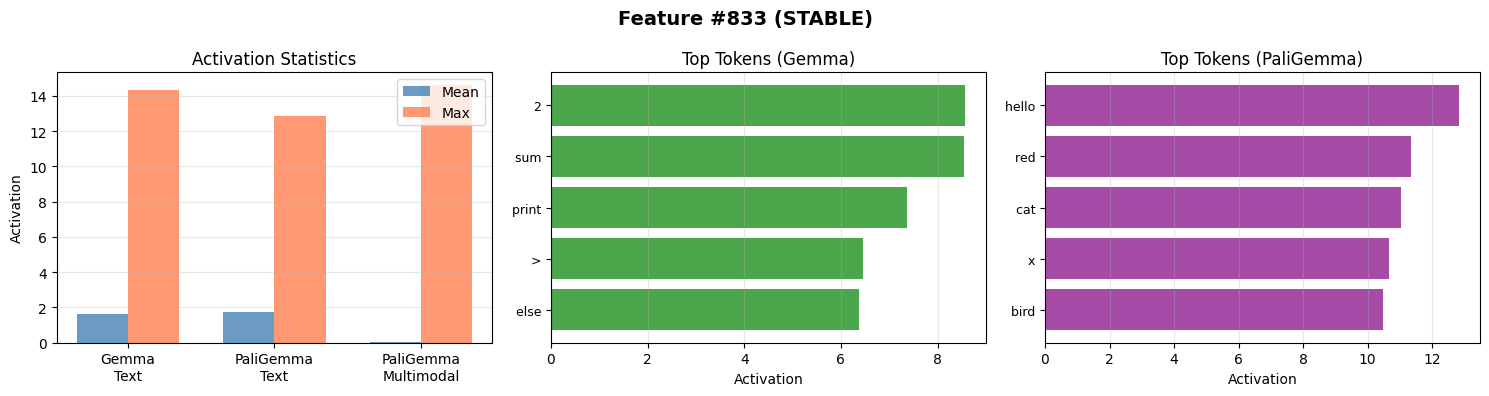

In [28]:
# ==========================================
# Cell 15: Analyze Stable Features
# ==========================================

print("=" * 60)
print("STABLE FEATURES - Similar activation patterns across models")
print("=" * 60)

stable_analyses = []
for i, feat_idx in enumerate(example_features.get('stable', [])[:4]):
    print(f"\n--- Stable Feature #{feat_idx} ---")
    analysis = analyze_single_feature(
        feat_idx, gemma_features, pali_text_features, pali_mm_features,
        gemma_tokens, paligemma_text_tokens, "stable"
    )
    stable_analyses.append(analysis)

    print(f"  Gemma mean: {analysis['gemma_mean']:.4f}, max: {analysis['gemma_max']:.4f}")
    print(f"  PaliGemma text mean: {analysis['pali_text_mean']:.4f}, max: {analysis['pali_text_max']:.4f}")
    print(f"  PaliGemma multimodal mean: {analysis['pali_mm_mean']:.4f}")
    print(f"  Top Gemma tokens: {[t[0] for t in analysis['gemma_top_tokens'][:3]]}")
    print(f"  Top PaliGemma tokens: {[t[0] for t in analysis['pali_text_top_tokens'][:3]]}")

    plot_feature_comparison(analysis, i)

### Example 2: Shifted Features

These features exist in both models but with different activation patterns - suggesting semantic adaptation during multimodal training.

SHIFTED FEATURES - Active in both but with different patterns

--- Shifted Feature #3031 ---
  Shift ratio (PaliGemma/Gemma): 3.30x
  Gemma mean: 7.5232
  PaliGemma text mean: 24.8032
  Top Gemma tokens: [' is', ' of', ' the']
  Top PaliGemma tokens: ['def', 'if', 'A']


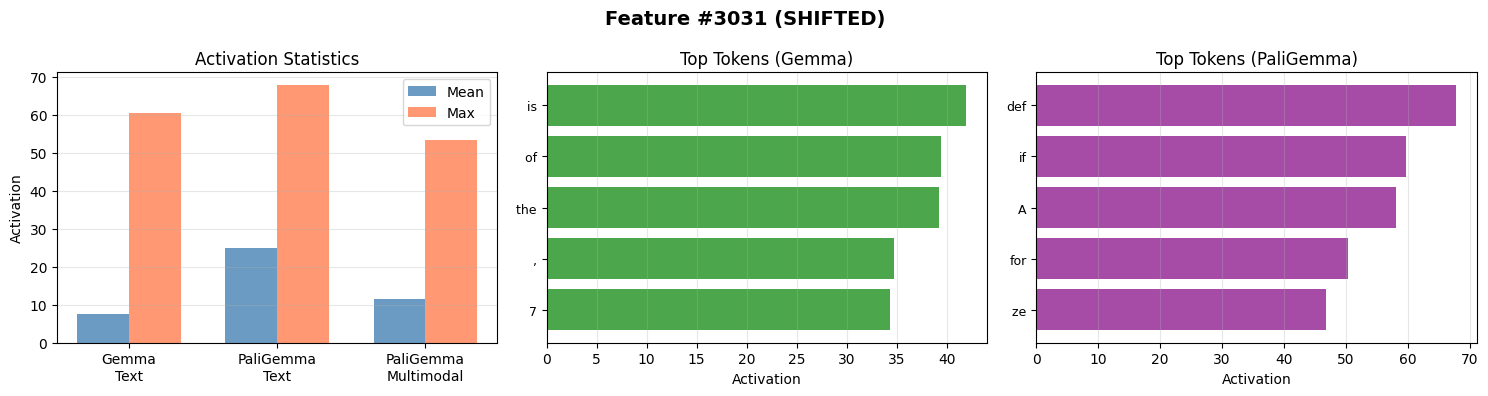


--- Shifted Feature #3910 ---
  Shift ratio (PaliGemma/Gemma): 0.37x
  Gemma mean: 4.0488
  PaliGemma text mean: 1.4946
  Top Gemma tokens: [':', ' high', ' i']
  Top PaliGemma tokens: ['Hello', ' active', "('"]


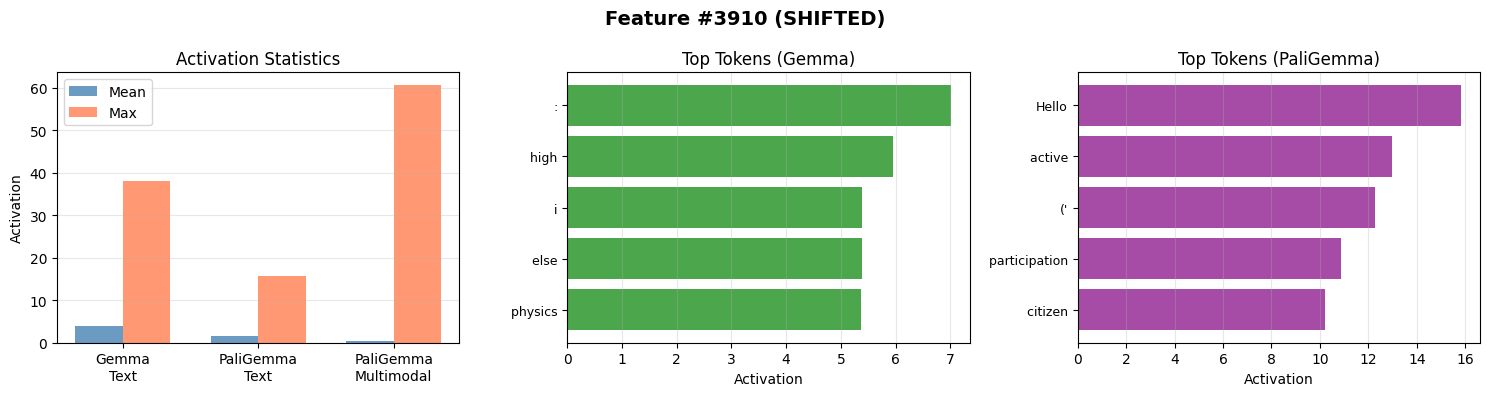


--- Shifted Feature #6639 ---
  Shift ratio (PaliGemma/Gemma): 0.41x
  Gemma mean: 4.0119
  PaliGemma text mean: 1.6484
  Top Gemma tokens: [' is', ' love', '8']
  Top PaliGemma tokens: [' beautiful', ' gracefully', ' answer']


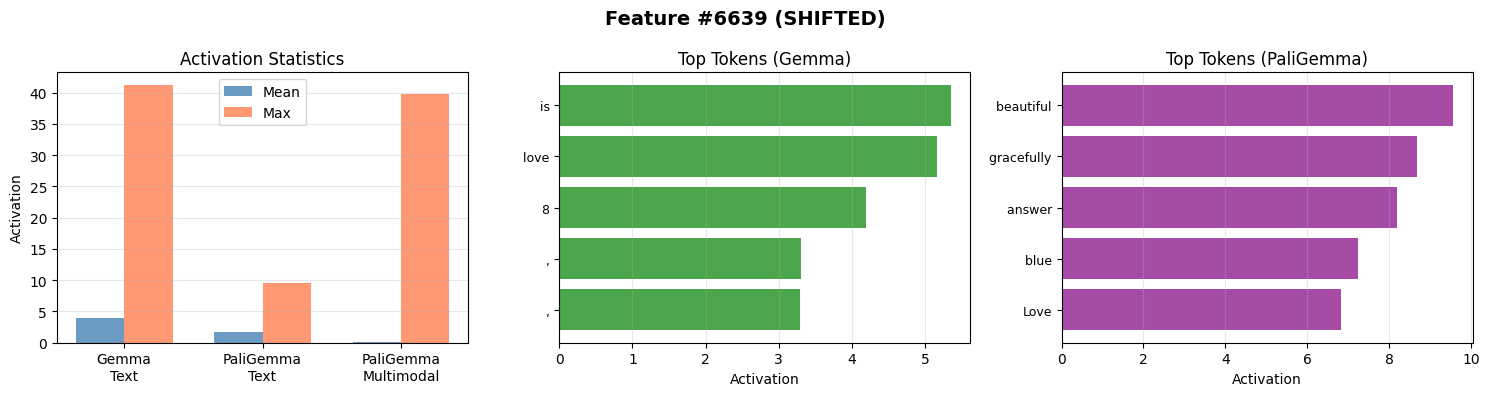


--- Shifted Feature #10324 ---
  Shift ratio (PaliGemma/Gemma): 0.50x
  Gemma mean: 3.7121
  PaliGemma text mean: 1.8518
  Top Gemma tokens: ['bras', ' participation', ' around']
  Top PaliGemma tokens: ['Democracy', ' active', ' requires']


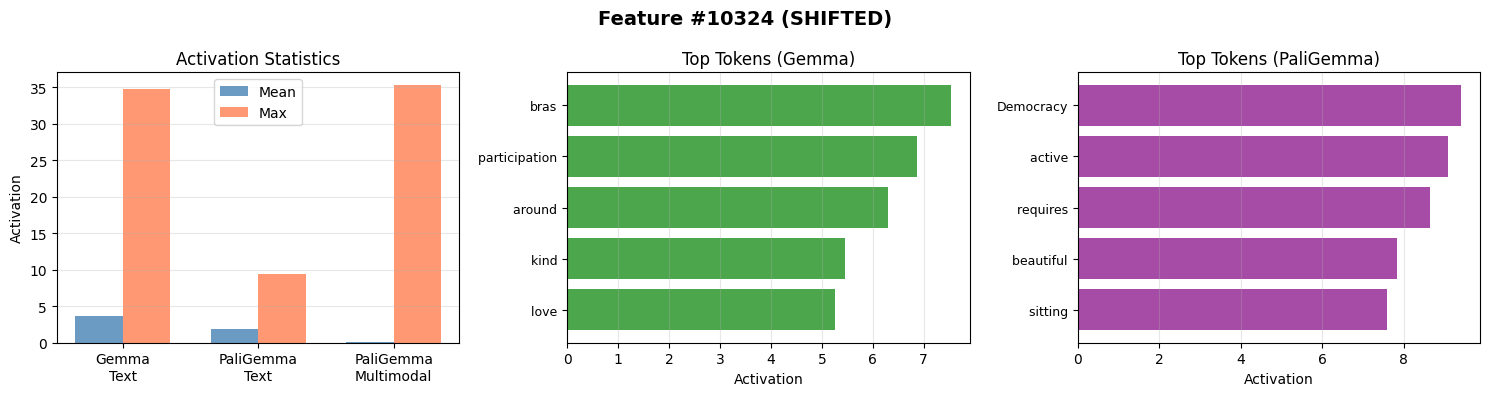

In [29]:
# ==========================================
# Cell 16: Analyze Shifted Features
# ==========================================

print("=" * 60)
print("SHIFTED FEATURES - Active in both but with different patterns")
print("=" * 60)

shifted_analyses = []
for i, feat_idx in enumerate(example_features.get('shifted', [])[:4]):
    print(f"\n--- Shifted Feature #{feat_idx} ---")
    analysis = analyze_single_feature(
        feat_idx, gemma_features, pali_text_features, pali_mm_features,
        gemma_tokens, paligemma_text_tokens, "shifted"
    )
    shifted_analyses.append(analysis)

    # Calculate shift magnitude
    shift_ratio = analysis['pali_text_mean'] / (analysis['gemma_mean'] + 1e-6)
    print(f"  Shift ratio (PaliGemma/Gemma): {shift_ratio:.2f}x")
    print(f"  Gemma mean: {analysis['gemma_mean']:.4f}")
    print(f"  PaliGemma text mean: {analysis['pali_text_mean']:.4f}")
    print(f"  Top Gemma tokens: {[t[0] for t in analysis['gemma_top_tokens'][:3]]}")
    print(f"  Top PaliGemma tokens: {[t[0] for t in analysis['pali_text_top_tokens'][:3]]}")

    plot_feature_comparison(analysis, i)

### Example 3: New Vision-Specific Features

These features are primarily active in PaliGemma when processing image inputs, suggesting they've been specialized for visual information.

NEW VISION-SPECIFIC FEATURES - Active mainly on image inputs

--- Vision-Specific Feature #7237 ---
  Vision boost: 586257.70x over Gemma
  Text boost: 1353053.81x over Gemma
  Gemma mean: 0.0000
  PaliGemma multimodal mean: 0.5863


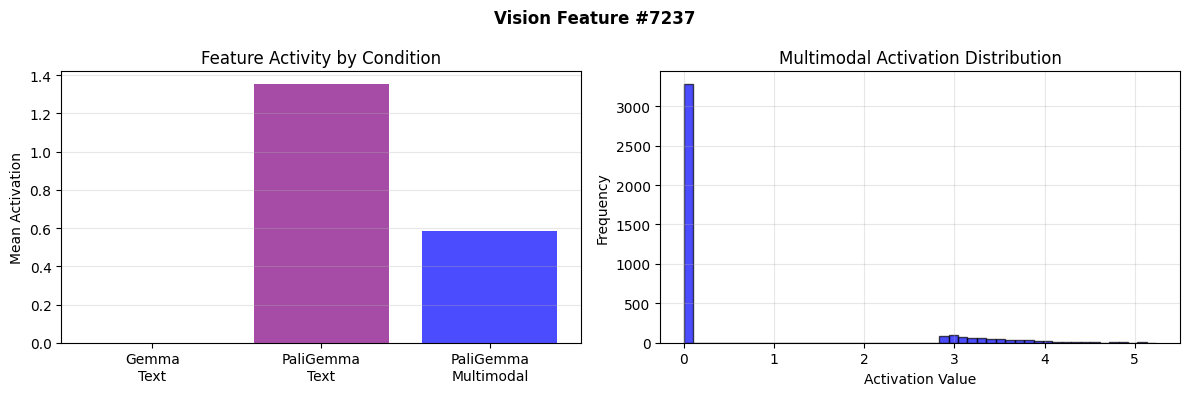


--- Vision-Specific Feature #10987 ---
  Vision boost: 536923.47x over Gemma
  Text boost: 0.00x over Gemma
  Gemma mean: 0.0000
  PaliGemma multimodal mean: 0.5369


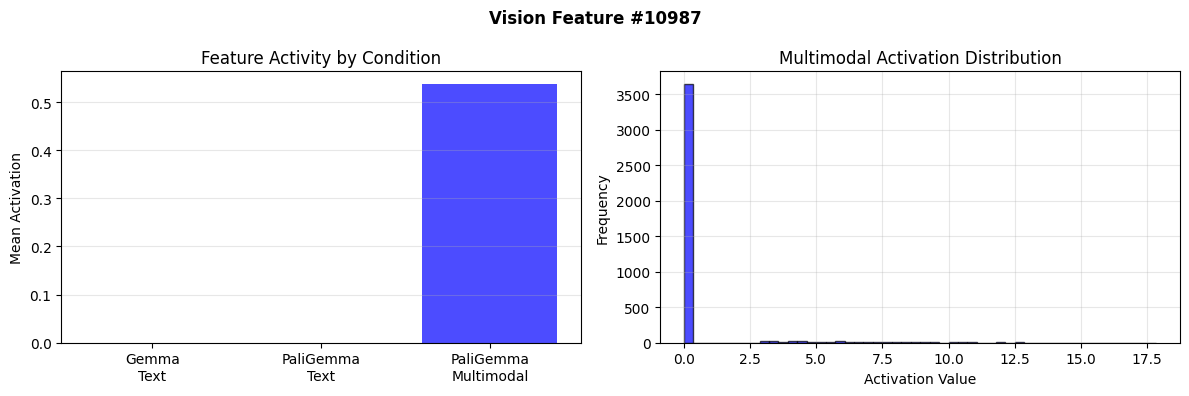


--- Vision-Specific Feature #6477 ---
  Vision boost: 35.64x over Gemma
  Text boost: 0.00x over Gemma
  Gemma mean: 0.0141
  PaliGemma multimodal mean: 0.5015


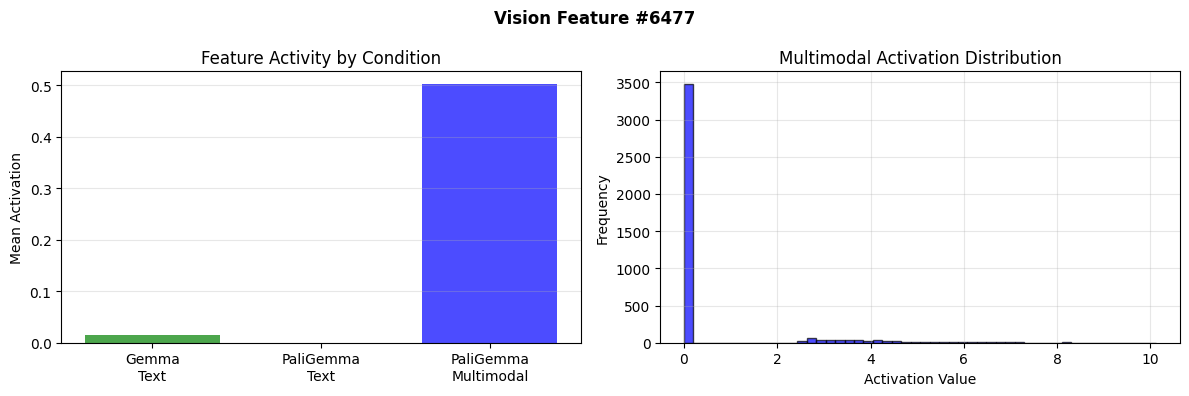


--- Vision-Specific Feature #10038 ---
  Vision boost: 19.09x over Gemma
  Text boost: 0.00x over Gemma
  Gemma mean: 0.0259
  PaliGemma multimodal mean: 0.4937


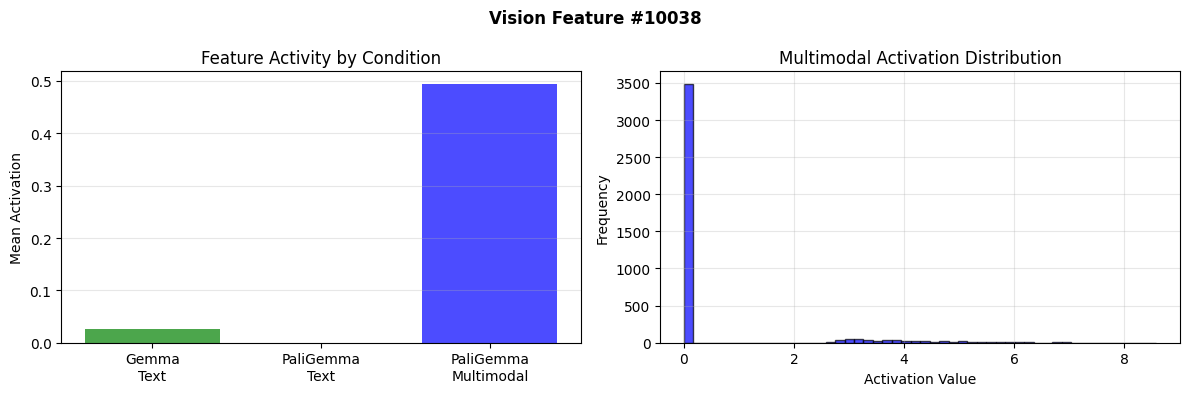

In [30]:
# ==========================================
# Cell 17: Analyze New Vision-Specific Features
# ==========================================

print("=" * 60)
print("NEW VISION-SPECIFIC FEATURES - Active mainly on image inputs")
print("=" * 60)

vision_analyses = []
for i, feat_idx in enumerate(example_features.get('new_vision', [])[:4]):
    print(f"\n--- Vision-Specific Feature #{feat_idx} ---")
    analysis = analyze_single_feature(
        feat_idx, gemma_features, pali_text_features, pali_mm_features,
        gemma_tokens, paligemma_text_tokens, "new_vision"
    )
    vision_analyses.append(analysis)

    # Calculate vision specificity
    vision_ratio = analysis['pali_mm_mean'] / (analysis['gemma_mean'] + 1e-6)
    text_ratio = analysis['pali_text_mean'] / (analysis['gemma_mean'] + 1e-6)
    print(f"  Vision boost: {vision_ratio:.2f}x over Gemma")
    print(f"  Text boost: {text_ratio:.2f}x over Gemma")
    print(f"  Gemma mean: {analysis['gemma_mean']:.4f}")
    print(f"  PaliGemma multimodal mean: {analysis['pali_mm_mean']:.4f}")

    # For vision features, show activation distribution across image positions
    feat_mm_acts = pali_mm_features[:, feat_idx]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f"Vision Feature #{feat_idx}", fontsize=12, fontweight='bold')

    # Activation comparison across conditions
    ax = axes[0]
    conditions = ['Gemma\nText', 'PaliGemma\nText', 'PaliGemma\nMultimodal']
    means = [analysis['gemma_mean'], analysis['pali_text_mean'], analysis['pali_mm_mean']]
    colors = ['green', 'purple', 'blue']
    bars = ax.bar(conditions, means, color=colors, alpha=0.7)
    ax.set_ylabel('Mean Activation')
    ax.set_title('Feature Activity by Condition')
    ax.grid(True, alpha=0.3, axis='y')

    # Histogram of multimodal activations
    ax = axes[1]
    ax.hist(feat_mm_acts.numpy(), bins=50, color='blue', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Activation Value')
    ax.set_ylabel('Frequency')
    ax.set_title('Multimodal Activation Distribution')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"figures/vision_feature_{feat_idx}.png", dpi=150, bbox_inches='tight')
    plt.show()

## Summary Visualization: Feature Transfer Landscape

A comprehensive view of how SAE features transfer from Gemma to PaliGemma.

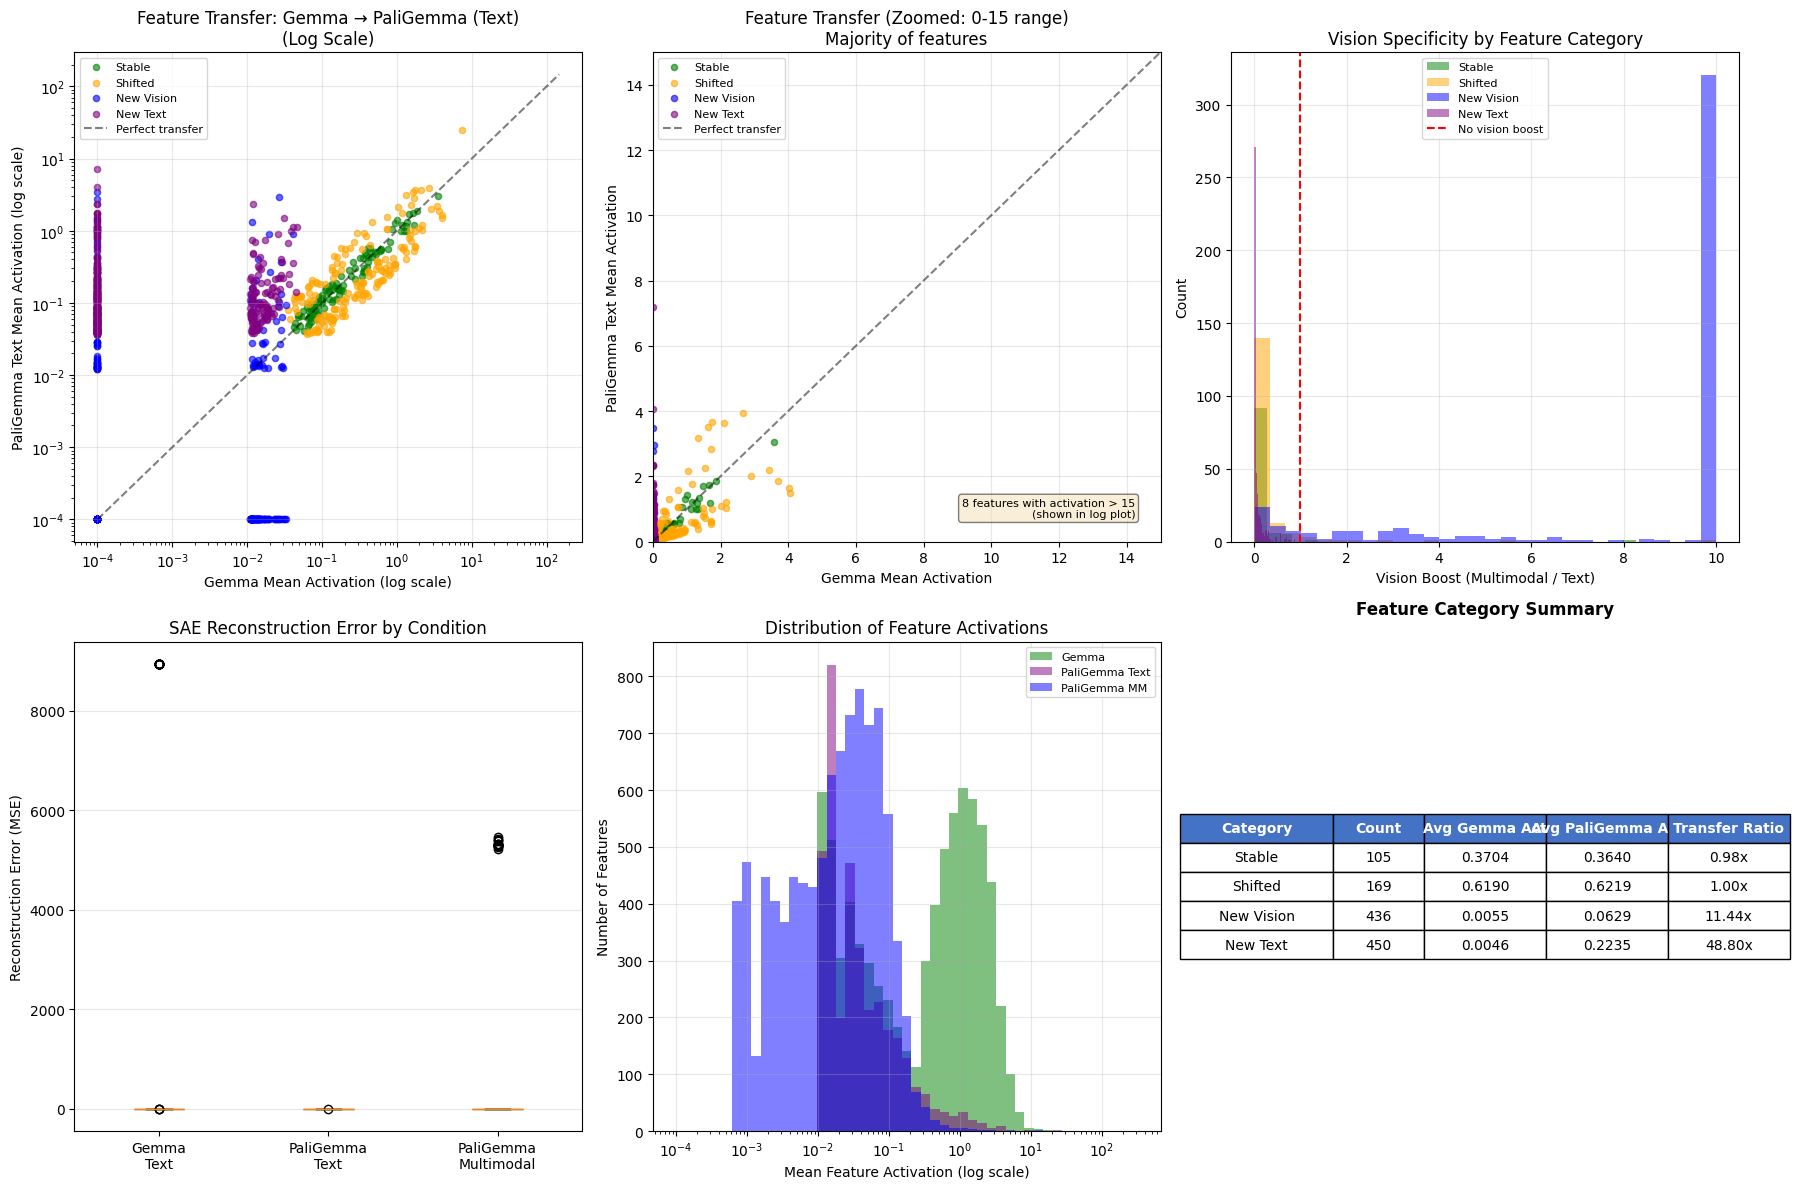


Summary saved to figures/sae_feature_transfer_summary.png


In [34]:
# ==========================================
# Cell 18: Summary Visualization
# ==========================================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: 2D scatter of feature transfer (log scale for better visibility)
ax = axes[0, 0]
colors_map = {'stable': 'green', 'shifted': 'orange', 'new_vision': 'blue', 'new_text': 'purple'}
for category, feat_indices in feature_classification.items():
    if feat_indices:
        # Add small epsilon to avoid log(0)
        g_acts = gemma_mean[feat_indices].numpy() + 1e-4
        p_acts = pali_text_mean[feat_indices].numpy() + 1e-4
        ax.scatter(g_acts, p_acts, label=category.replace('_', ' ').title(),
                  color=colors_map[category], alpha=0.6, s=20)

# Diagonal line for perfect transfer
max_val = max(gemma_mean.max().item(), pali_text_mean.max().item())
ax.plot([1e-4, max_val], [1e-4, max_val], 'k--', alpha=0.5, label='Perfect transfer')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Gemma Mean Activation (log scale)")
ax.set_ylabel("PaliGemma Text Mean Activation (log scale)")
ax.set_title("Feature Transfer: Gemma → PaliGemma (Text)\n(Log Scale)")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 2: Zoomed linear view (focus on main cluster)
ax = axes[0, 1]
for category, feat_indices in feature_classification.items():
    if feat_indices:
        g_acts = gemma_mean[feat_indices].numpy()
        p_acts = pali_text_mean[feat_indices].numpy()
        ax.scatter(g_acts, p_acts, label=category.replace('_', ' ').title(),
                  color=colors_map[category], alpha=0.6, s=20)

ax.plot([0, 15], [0, 15], 'k--', alpha=0.5, label='Perfect transfer')
ax.set_xlim(0, 15)
ax.set_ylim(0, 15)
ax.set_xlabel("Gemma Mean Activation")
ax.set_ylabel("PaliGemma Text Mean Activation")
ax.set_title("Feature Transfer (Zoomed: 0-15 range)\nMajority of features")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Add annotation about outliers
n_outliers = ((gemma_mean > 15) | (pali_text_mean > 15)).sum().item()
ax.annotate(f'{n_outliers} features with activation > 15\n(shown in log plot)',
            xy=(0.95, 0.05), xycoords='axes fraction', ha='right', fontsize=8,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 3: Vision specificity analysis
ax = axes[0, 2]
vision_boost = (pali_mm_mean / (pali_text_mean + 1e-6)).numpy()
vision_boost = np.clip(vision_boost, 0, 10)  # Clip for visualization

for category, feat_indices in feature_classification.items():
    if feat_indices:
        boosts = vision_boost[feat_indices]
        ax.hist(boosts, bins=30, alpha=0.5, label=category.replace('_', ' ').title(),
               color=colors_map[category])

ax.axvline(x=1.0, color='red', linestyle='--', label='No vision boost')
ax.set_xlabel("Vision Boost (Multimodal / Text)")
ax.set_ylabel("Count")
ax.set_title("Vision Specificity by Feature Category")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 4: Feature reconstruction error comparison
ax = axes[1, 0]
# Compute reconstruction errors for each model
# sae-lens SAE uses decode(encode(x)) for reconstruction
with torch.no_grad():
    # Move to device for SAE encoding/decoding
    gemma_flat_device = gemma_flat.to(DEVICE)
    pali_text_flat_device = pali_text_flat.to(DEVICE)
    pali_mm_flat_device = pali_mm_flat.to(DEVICE)

    gemma_recon = sae.decode(sae.encode(gemma_flat_device))
    pali_text_recon = sae.decode(sae.encode(pali_text_flat_device))
    pali_mm_recon = sae.decode(sae.encode(pali_mm_flat_device))

    gemma_error = F.mse_loss(gemma_recon, gemma_flat_device, reduction='none').mean(dim=1).cpu()
    pali_text_error = F.mse_loss(pali_text_recon, pali_text_flat_device, reduction='none').mean(dim=1).cpu()
    pali_mm_error = F.mse_loss(pali_mm_recon, pali_mm_flat_device, reduction='none').mean(dim=1).cpu()

data = [gemma_error.numpy(), pali_text_error.numpy(), pali_mm_error.numpy()]
labels = ['Gemma\nText', 'PaliGemma\nText', 'PaliGemma\nMultimodal']
bp = ax.boxplot(data, labels=labels, patch_artist=True)
colors_box = ['green', 'purple', 'blue']
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax.set_ylabel("Reconstruction Error (MSE)")
ax.set_title("SAE Reconstruction Error by Condition")
ax.grid(True, alpha=0.3, axis='y')

# Plot 5: Activation distribution comparison (new plot)
ax = axes[1, 1]
# Show distribution of mean activations for each condition
bins = np.logspace(-4, 2.5, 50)  # Log-spaced bins
ax.hist(gemma_mean.numpy() + 1e-4, bins=bins, alpha=0.5, label='Gemma', color='green')
ax.hist(pali_text_mean.numpy() + 1e-4, bins=bins, alpha=0.5, label='PaliGemma Text', color='purple')
ax.hist(pali_mm_mean.numpy() + 1e-4, bins=bins, alpha=0.5, label='PaliGemma MM', color='blue')
ax.set_xscale('log')
ax.set_xlabel("Mean Feature Activation (log scale)")
ax.set_ylabel("Number of Features")
ax.set_title("Distribution of Feature Activations")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 6: Summary statistics table
ax = axes[1, 2]
ax.axis('off')

# Create summary table
summary_data = [
    ["Category", "Count", "Avg Gemma Act", "Avg PaliGemma Act", "Transfer Ratio"],
]

for cat, indices in feature_classification.items():
    if indices:
        g_avg = gemma_mean[indices].mean().item()
        p_avg = pali_text_mean[indices].mean().item()
        ratio = p_avg / (g_avg + 1e-6)
        summary_data.append([
            cat.replace('_', ' ').title(),
            str(len(indices)),
            f"{g_avg:.4f}",
            f"{p_avg:.4f}",
            f"{ratio:.2f}x"
        ])

table = ax.table(
    cellText=summary_data,
    loc='center',
    cellLoc='center',
    colWidths=[0.25, 0.15, 0.2, 0.2, 0.2]
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

# Make header row bold
for i in range(5):
    table[(0, i)].set_text_props(fontweight='bold')
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(color='white')

ax.set_title("Feature Category Summary", fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig("figures/sae_feature_transfer_summary.png", dpi=200, bbox_inches='tight')
plt.show()

print("\nSummary saved to figures/sae_feature_transfer_summary.png")

## Conclusions

This experiment analyzed how SAE features transfer from Gemma-base to PaliGemma during multimodal adaptation:

### Key Findings:

1. **Stable Features**: Many features maintain similar activation patterns, suggesting core linguistic representations are preserved during multimodal training.

2. **Shifted Features**: Some features are active in both models but with different patterns - these may represent concepts that gain visual grounding or change meaning in the multimodal context.

3. **New Vision-Specific Features**: Features that activate primarily on image inputs in PaliGemma suggest the model develops specialized representations for visual information.

### Implications for SAE Transfer:

- Reconstruction error alone is indeed too coarse - feature-level analysis reveals a more nuanced picture of how representations change.
- The SAE trained on Gemma can partially decode PaliGemma representations, but vision-specific information requires different features.
- This analysis framework can guide decisions about when to retrain SAEs vs. adapt existing ones for multimodal models.

In [33]:
# ==========================================
# Cell 19: Export Results Summary
# ==========================================

import pandas as pd

# Create a DataFrame with detailed feature analysis
results = []
for category, indices in feature_classification.items():
    for idx in indices[:50]:  # Limit to top 50 per category for export
        results.append({
            'feature_idx': idx,
            'category': category,
            'gemma_mean_activation': gemma_mean[idx].item(),
            'gemma_max_activation': gemma_max[idx].item(),
            'paligemma_text_mean': pali_text_mean[idx].item(),
            'paligemma_text_max': pali_text_max[idx].item(),
            'paligemma_mm_mean': pali_mm_mean[idx].item(),
            'paligemma_mm_max': pali_mm_max[idx].item(),
            'transfer_ratio': pali_text_mean[idx].item() / (gemma_mean[idx].item() + 1e-6),
            'vision_boost': pali_mm_mean[idx].item() / (pali_text_mean[idx].item() + 1e-6),
        })

df = pd.DataFrame(results)
df.to_csv('sae_feature_analysis_results.csv', index=False)

print(f"Exported {len(results)} feature analyses to sae_feature_analysis_results.csv")
print("\nSample results:")
display(df.head(10))

Exported 200 feature analyses to sae_feature_analysis_results.csv

Sample results:


,feature_idx,category,gemma_mean_activation,gemma_max_activation,paligemma_text_mean,paligemma_text_max,paligemma_mm_mean,paligemma_mm_max,transfer_ratio,vision_boost
0,90,stable,0.279968,5.765229,0.304212,5.671369,0.018480,4.435650,1.086593,0.060746
1,112,stable,0.085591,4.453392,0.070019,3.697050,0.034959,5.992566,0.818056,0.499277
2,274,stable,0.103023,12.753811,0.116063,4.429042,0.014094,3.899933,1.126563,0.121429
3,328,stable,0.324537,3.448210,0.423682,5.063314,0.002277,3.290823,1.305490,0.005374
4,337,stable,0.355304,6.273544,0.270420,5.379519,0.066015,4.587915,0.761094,0.244120
5,810,stable,0.107884,9.740510,0.150558,11.623733,0.000000,0.000000,1.395545,0.000000
6,817,stable,0.769225,38.915634,0.566499,26.749065,0.000000,0.000000,0.736453,0.000000
7,833,stable,1.648377,14.323825,1.745857,12.836337,0.053367,14.605281,1.059136,0.030568
8,855,stable,0.462986,31.627016,0.431387,22.893400,0.000000,0.000000,0.931748,0.000000
9,1049,stable,0.616284,6.548015,0.561212,4.989389,0.025682,4.623805,0.910637,0.045761
